In [1]:
import numpy as np 
from scipy import signal
import sys 
import os
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath("/Users/samgende/Documents/Bachelor/DAS-Unsupervised-Noise-Filtering"))
from Code.utilities import DAS
import scipy.ndimage
import scipy.signal
import matplotlib.patches as patches
from matplotlib.patches import Patch
from scipy.signal import correlate

In [2]:
# Works on older versions of scipy
def correlate_func(x, idx, cc_thresh = 0.9):
    correlation = correlate(x[idx,:], x[(idx+1),:], mode="full")
    lags = np.arange(-(x[idx,:].size - 1), x[(idx+1),:].size)
    lag_idx = np.argmax(correlation)
    lag = lags[lag_idx]
    if lag > 0:
        if np.corrcoef(x[idx,lag:], x[(idx+1),:-lag], rowvar=False)[0,1] > cc_thresh:
            x = np.concatenate(
                [np.concatenate([x[:(idx+1),:], np.zeros((x[:(idx+1),:].shape[0], lag))], axis=1),
                 np.concatenate([np.zeros((x[(idx+1):,:].shape[0], lag)), x[(idx+1):,:]], axis=1)],
                axis=0)
    if lag < 0:
        if np.corrcoef(x[idx,:-lag], x[(idx+1),lag:], rowvar=False)[0,1] > cc_thresh:
            x = np.concatenate(
                [np.concatenate([np.zeros((x[:(idx+1),:].shape[0], abs(lag))), x[:(idx+1),:]], axis=1),
                 np.concatenate([x[(idx+1):,:], np.zeros((x[(idx+1):,:].shape[0], abs(lag)))], axis=1)],
                axis=0)

    return(x)

# Looks at all previous channels in window and shifts relative to channel with highest xcorr
def correlate_func2(x, idx, cc_thresh = 0.9):
    correlation = correlate(x[:idx,:], x[(idx+1):(idx+2),:], mode="full", method="direct")
    idx_max_xcorr = np.argmax(np.amax(correlation, axis=1))

    lags = np.arange(-(x[idx_max_xcorr,:].size - 1), x[(idx+1),:].size)
    lag_idx = np.argmax(correlation[idx_max_xcorr,:])
    lag = lags[lag_idx]

    if lag > 0:
        if np.corrcoef(x[idx_max_xcorr,lag:], x[(idx+1),:-lag], rowvar=False)[0,1] > cc_thresh:
            # Need to check difference in zeros at start
            idx_max_xcorr_start = np.amin(np.where(x[idx_max_xcorr,:] != 0))
            idx_plus1_start = np.amin(np.where(x[(idx+1),:] != 0))
            lag = lag - (idx_plus1_start - idx_max_xcorr_start)
            if lag > 0:
                # Concatenate zeros to shift signal
                x = np.concatenate(
                    [np.concatenate([x[:(idx+1),:], np.zeros((x[:(idx+1),:].shape[0], lag))], axis=1),
                     np.concatenate([np.zeros((x[(idx+1):,:].shape[0], lag)), x[(idx+1):,:]], axis=1)],
                    axis=0)
    if lag < 0:
        if np.corrcoef(x[idx,:-lag], x[(idx+1),lag:], rowvar=False)[0,1] > cc_thresh:
            # Need to check difference in zeros at start
            idx_max_xcorr_start = np.amin(np.where(x[idx_max_xcorr,:] != 0))
            idx_plus1_start = np.amin(np.where(x[(idx+1),:] != 0))
            lag = lag + (idx_plus1_start - idx_max_xcorr_start)
            if lag < 0:
                # Concatenate zeros to shift signal
                x = np.concatenate(
                    [np.concatenate([np.zeros((x[:(idx+1),:].shape[0], abs(lag))), x[:(idx+1),:]], axis=1),
                     np.concatenate([x[(idx+1):,:], np.zeros((x[(idx+1):,:].shape[0], abs(lag)))], axis=1)],
                    axis=0)

    return(x)


# This is equal to first part of Eq 7 in https://doi.org/10.1111/1365-2478.13178
def marfurt_semblance(region):
    region = region.reshape(-1, region.shape[-1])
    ntraces, nsamples = region.shape

    # Cross correlation and shift
    #this didn't change semblance
    
    for i in range(ntraces-1):
        region = correlate_func(region, i, cc_thresh = 0.7)
    
    

    square_of_sums = np.sum(region, axis=0)**2
    sum_of_squares = np.sum(region**2, axis=0)
    sembl = square_of_sums.sum() / sum_of_squares.sum()
    return sembl / ntraces

def moving_window(data, window, func):
    wrapped = lambda region: func(region.reshape(window))
    return scipy.ndimage.generic_filter(data, wrapped, window)

no_chan = 500
no_samp = 500

In [3]:
#Test semblance with New Zealand data 
dir = "../Data/2023p152354"
files = os.listdir(dir)[:1]
#NZ_raw = np.zeros((2449, 12000))
i = 0
files.sort()
NZ_raw ,startime = DAS.open_H5_file(f'../Data/2023p313442/south30_50Hz_UTC_20230426_232007.359.h5')
'''for file in files:
    print(i)
    das ,startime = DAS.open_H5_file(f'{dir}/{file}')
    NZ_raw[:, i*3000:(i+1)*3000] = das.T
    break 
    i+= 1'''

print(no_chan)
print(no_samp)


#print(f'singal to noise ratio of raw DAS is {SNR_sem(DAS_Stanford_raw)}')
#print(f'singal to noise ratio of processesd DAS is  {SNR_sem(proccessed_DAS)}')
smaller_NZ_DAS = NZ_raw[:1000, 1000:2000]
print(NZ_raw.shape)

#S_raw_ex = moving_window(smaller_NZ_DAS.T, (no_chan, no_samp), marfurt_semblance)

(3000, 7488)
500
500
(3000, 2449)


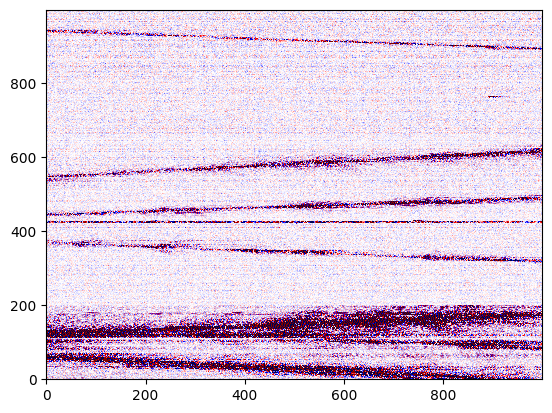

In [4]:
plt.imshow((smaller_NZ_DAS.T/ smaller_NZ_DAS.T.std()), origin = 'lower', interpolation='nearest', cmap='seismic', aspect='auto', vmin=-1, vmax=1)

In [ ]:
plt.imshow(S_raw_ex, aspect='auto')
plt.colorbar()